In [25]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math

<h1>Data Prep</h1>

In [6]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('test_data/names/*.txt'))

all_letters = string.ascii_letters + " .,;''"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('test_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


['test_data/names\\Arabic.txt', 'test_data/names\\Chinese.txt', 'test_data/names\\Czech.txt', 'test_data/names\\Dutch.txt', 'test_data/names\\English.txt', 'test_data/names\\French.txt', 'test_data/names\\German.txt', 'test_data/names\\Greek.txt', 'test_data/names\\Irish.txt', 'test_data/names\\Italian.txt', 'test_data/names\\Japanese.txt', 'test_data/names\\Korean.txt', 'test_data/names\\Polish.txt', 'test_data/names\\Portuguese.txt', 'test_data/names\\Russian.txt', 'test_data/names\\Scottish.txt', 'test_data/names\\Spanish.txt', 'test_data/names\\Vietnamese.txt']
Slusarski


In [12]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    
    return tensor

print(letterToTensor('J').size())
print(lineToTensor('Jones').size())

torch.Size([1, 58])
torch.Size([5, 1, 58])


<h1>Recurrent Neural Network</h1>

In [29]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [18]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9379, -2.9470, -2.8788, -2.8108, -2.8063, -2.9165, -2.9712, -2.9200,
         -2.9010, -2.9562, -2.7977, -2.8127, -2.8730, -3.0107, -2.9296, -2.8409,
         -2.8750, -2.8741]], grad_fn=<LogSoftmaxBackward>)


<h3>Training</h3>

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


In [23]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Cai
category = Japanese / line = Chiba
category = Dutch / line = Kolijn
category = Portuguese / line = Machado
category = Irish / line = Naomhan
category = Italian / line = Caruso
category = Chinese / line = Peng
category = French / line = Emile
category = Dutch / line = Spijker
category = Spanish / line = Espino


In [24]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()
    

In [31]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
    

5000 5% (0m 14s) 1.9489 Kuang / Chinese ✓
10000 10% (0m 28s) 1.7486 Ngai / Chinese ✗ (Korean)
15000 15% (0m 42s) 1.5615 Oirschotten / Dutch ✓
20000 20% (0m 56s) 0.8641 Kan / Chinese ✓
25000 25% (1m 9s) 2.8881 Aloia / Arabic ✗ (Italian)
30000 30% (1m 24s) 1.9377 Flavell / Spanish ✗ (English)
35000 35% (1m 38s) 2.9887 Bonfils / Greek ✗ (French)
40000 40% (1m 52s) 1.0858 Sneiders / Dutch ✓
45000 45% (2m 7s) 0.5909 Yatsyshin / Russian ✓
50000 50% (2m 22s) 0.6838 Scordato / Italian ✓
55000 55% (2m 37s) 1.3471 Schmitz / German ✓
60000 60% (2m 51s) 2.9534 Alker / German ✗ (English)
65000 65% (3m 5s) 0.1038 Koumanidis / Greek ✓
70000 70% (3m 21s) 0.5851 Narahashi / Japanese ✓
75000 75% (3m 36s) 0.9732 Dubhshlaine / Irish ✓
80000 80% (3m 52s) 0.9148 Ha / Vietnamese ✓
85000 85% (4m 8s) 1.5056 Quraishi / Japanese ✗ (Arabic)
90000 90% (4m 23s) 0.2332 Rosario / Portuguese ✓
95000 95% (4m 38s) 0.7485 White / Scottish ✓
100000 100% (4m 54s) 0.0513 Conti / Italian ✓


<h1>Evaluation</h1>

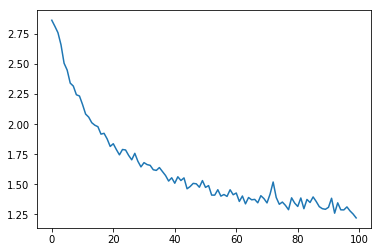

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

<h3>Confusion Matrix</h3>

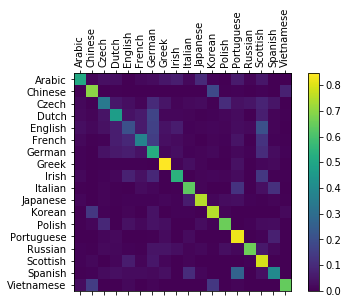

In [34]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()